In [1]:
import numpy as np
import matplotlib.pyplot as plt
from banded import banded

In [ ]:
# Parameters
N = 1000
D = 1e-8 # m
a = D/N # m

x0 = D/2
sigma = 1e-10 # m
kappa = 5e10 # 1/m
h = 1e-18 # s
hbar = 1.0545718e-34 # J*s
m_e = 9.109e-31 # kg

In [ ]:
# Initial wavefunction
x = np.linspace(0, D, N)
psi0 = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * kappa * x)
psi0[0] = 0+0j
psi0[-1] = 0+0j

Text(0, 0.5, '$|\\psi(x,0)|^2$')

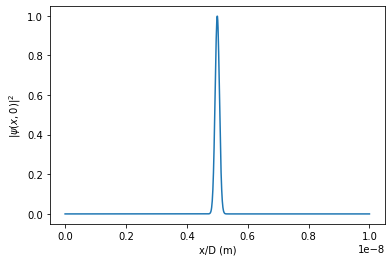

In [ ]:
# Show initial wavefunction
plt.plot(x, np.abs(psi0)**2)
plt.xlabel('x/D (m)')
plt.ylabel(r'$|\psi(x,0)|^2$')

In [ ]:
# Define matrices A and B
a1 = 1 + h * 1j * hbar / (2 * m_e * a**2)
a2 = - h * 1j * hbar / (4 * m_e * a**2)
b1 = 1 - h * 1j * hbar / (2 * m_e * a**2)
b2 = h * 1j * hbar / (4 * m_e * a**2)

A = np.diag(np.full(N, a1)) + np.diag(np.full(N-1, a2), 1) + np.diag(np.full(N-1, a2), -1)
B = np.diag(np.full(N, b1)) + np.diag(np.full(N-1, b2), 1) + np.diag(np.full(N-1, b2), -1)

A[0,:] = 0
A[0,0] = 1
A[-1,:] = 0
A[-1,-1] = 1

B[0,:] = 0
B[-1,:] = 0

In [ ]:
# Convert to banded form for use with banded.py
up = 1
down = 1

A_banded = np.zeros((1+up+down, N), dtype=complex)
A_banded[1] = a1   
A_banded[0, 1:] = a2  
A_banded[2, :-1] = a2 

# Boundary conditions
A_banded[1,0]   = 1   
A_banded[0,0]   = 0   
A_banded[2,0]   = 0      

A_banded[1,-1]  = 1
A_banded[0,-1]  = 0
A_banded[2,-1]  = 0

In [ ]:
# Step 1: v = B @ psi
v = B @ psi0

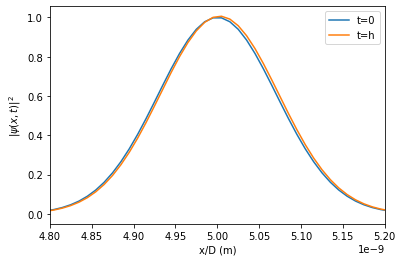

In [38]:
plt.plot(x, np.abs(psi0)**2, label='t=0')
plt.plot(x, np.abs(v)**2, label='t=h')
plt.xlim(4.8e-9, 5.2e-9)
plt.xlabel('x/D (m)')
plt.ylabel(r'$|\psi(x,t)|^2$')
plt.legend()

In [39]:
# Step 2: solve A @ psi = v for psi
psi = banded(A_banded, v, 1, 1)
# psi = np.linalg.solve(A, v)

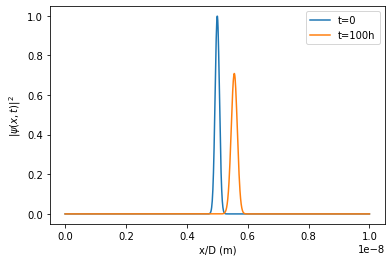

In [ ]:
# Repeat steps 1 and 2

v = B @ psi0
psi = banded(A_banded, v, 1, 1)
# psi = np.linalg.solve(A, v)
for step in range(100):
    v = B @ psi
    psi = banded(A_banded, v, 1, 1)
    # psi = np.linalg.solve(A, v)

plt.plot(x, np.abs(psi)**2, label='t=100h')
plt.plot(x, np.abs(psi0)**2, label='t=0')

plt.xlabel('x/D (m)')
plt.ylabel(r'$|\psi(x,t)|^2$')

plt.legend()


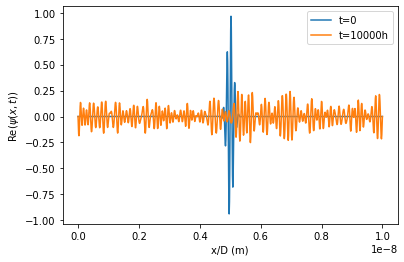

In [ ]:
# Repeat steps 1 and 2
psi = psi0.copy()

for step in range(100000):
    v = b1 * psi.copy()
    v[:-1] += b2 * psi[1:]
    v[1:]  += b2 * psi[:-1]
    v[0] = 0+0j
    v[-1] = 0+0j

    # Step 2 using banded.py 
    psi_new = banded(A_banded, v, up, down)
    psi_new[0] = 0+0j
    psi_new[-1] = 0+0j

    # Update psi
    psi[:] = psi_new

In [104]:
h * 100000

1e-13

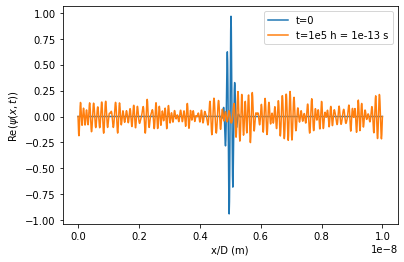

In [107]:
plt.plot(x, np.real(psi0), label='t=0')
plt.plot(x, np.real(psi), label='t=1e5 h = 1e-13 s')

plt.xlabel('x/D (m)')
plt.ylabel(r'Re$(\psi(x,t))$')

plt.legend()

In [108]:
np.sum(np.abs(psi)**2)*a, np.sum(np.abs(psi0)**2)*a

(1.770681397055855e-10, 1.77068139705461e-10)

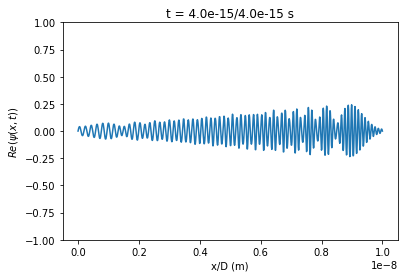

In [ ]:
from matplotlib import animation

# adjust these as needed
n_steps = 4000
fps = 40
# xlim = (x0 - 5*sigma, x0 + 5*sigma)  # zoom around initial packet; uses existing x0 and sigma

psi = psi0.copy()

fig, ax = plt.subplots()
line, = ax.plot(x, np.abs(psi)**2)
# ax.set_xlim(xlim)
ax.set_ylim(-1, 1)
ax.set_xlabel('x/D (m)')
ax.set_ylabel(r'$Re(\psi(x,t))$')

def update(frame):
    v = B @ psi
    psi_new = banded(A_banded, v, up, down)
    psi_new[0] = 0
    psi_new[-1] = 0
    # psi_new = np.linalg.solve(A, v)
    psi[:] = psi_new
    line.set_ydata(np.real(psi))
    ax.set_title(f't = {(frame+1) * h:.1e}/{n_steps * h:.1e} s')
    return (line,)

anim = animation.FuncAnimation(fig, update, frames=n_steps, interval=1000/fps, blit=False)

writer = animation.PillowWriter(fps=fps)
# anim.save('wave_evolution.gif', writer=writer)

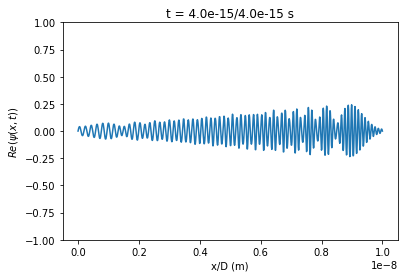

In [ ]:
n_steps = 4000
fps = 50

# Initialize
psi = psi0.copy()

# Plot setup
fig, ax = plt.subplots()
line, = ax.plot(x, np.abs(psi)**2)
ax.set_ylim(-1, 1)
ax.set_xlabel('x/D (m)')
ax.set_ylabel(r'$Re(\psi(x,t))$')

def update(frame):
    # Step 1 without matrix multiplication for faster computation
    v = b1 * psi.copy()
    v[:-1] += b2 * psi[1:]
    v[1:]  += b2 * psi[:-1]
    v[0] = 0+0j
    v[-1] = 0+0j

    # Step 2 using banded.py 
    psi_new = banded(A_banded, v, up, down)
    psi_new[0] = 0+0j
    psi_new[-1] = 0+0j

    # Update psi
    psi[:] = psi_new

    # Update plot
    line.set_ydata(np.real(psi))
    ax.set_title(f't = {(frame+1) * h:.1e}/{n_steps * h:.1e} s')
    return (line,)

anim = animation.FuncAnimation(fig, update, frames=n_steps, interval=1000/fps, blit=False)

writer = animation.PillowWriter(fps=fps)
anim.save('wave_evolution.gif', writer=writer)